# Toy 01: measuring appearance & bias

HOWTO: run the dataset & model cells, then run either of the solution cells following by the analysis cell.

In [2]:
%load_ext autoreload

# Dataset

In [3]:
# import torch

# COLORS = [
#     ([0.0, 0.0, 0.0], 'black'),
#     ([1.0, 0.0, 0.0], 'red'),
#     ([0.0, 1.0, 0.0], 'green'),
#     ([0.0, 0.0, 1.0], 'blue'),
#     ([1.0, 1.0, 0.0], 'yellow'),
#     ([1.0, 0.0, 1.0], 'magenta'),
#     ([0.0, 1.0, 1.0], 'cyan'),
#     ([1.0, 1.0, 1.0], 'white'),
# ]

# def multicolored_random_positions_toy_dataset(size=[5,5]):
#     """Create a dataset where each image has one pixel, and the color of the pixel determines the class."""
#     images = []
#     labels = []
#     for t, (vals, c) in enumerate(COLORS):
#         for y1 in range(size[0]):
#             for x1 in range(size[1]):
#                 image = torch.rand([3] + size) * 0.0
#                 image[0, y1, x1] = vals[0]
#                 image[1, y1, x1] = vals[1]
#                 image[2, y1, x1] = vals[2]

#                 images.append(image)
#                 labels.append(t)

#     images = torch.stack(images)
#     labels = torch.tensor(labels, dtype=torch.long)
#     return images, labels

# images, labels = multicolored_random_positions_toy_dataset()

%autoreload
import datasets

images, labels, n_classes, sort_groups, = datasets.dataset_mixed_position(0, 6)
train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels = datasets.split_dataset(images, labels)

216 training samples
216 test samples
216 analysis samples


In [4]:
# # DEBUG: test specific sample attribution
# analysis_indices = train_labels == 2
# analysis_images = train_images[analysis_indices]
# analysis_labels = train_labels[analysis_indices]

# print(f"{train_images.shape[0]} training samples")
# print(f"{test_images.shape[0]} test samples")
# print(f"{analysis_images.shape[0]} analysis samples")

200 training samples
200 test samples
25 analysis samples


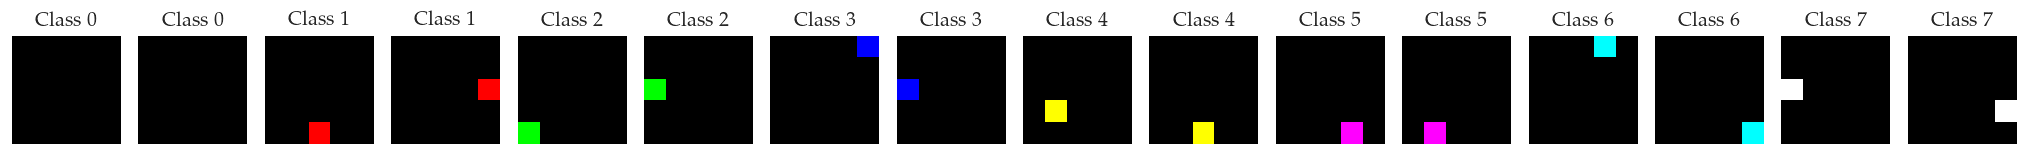

In [11]:
# import matplotlib
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.style.use(['seaborn'])
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Palatino"]})
# matplotlib.rcParams['mathtext.fontset'] = 'stix'
# matplotlib.rcParams['font.family'] = 'STIXGeneral'

# n_colors = n_classes
# fig, axs = plt.subplots(1, 2 * n_colors, figsize=(1 + 2 * n_colors, 2), dpi=120)
# j = 0
# for c in range(n_classes):
#     for i in range(2):
#         inds = train_labels == c
#         axs[j].imshow(train_images[inds][i].permute((1, 2, 0)))
#         axs[j].set_title(f"Class {train_labels[inds][i]}")
#         # inds = analysis_labels == c
#         # if len(analysis_images[inds]) > 0:
#         #     axs[j].imshow(analysis_images[inds][i].permute((1, 2, 0)))
#         #     axs[j].set_title(f"Class {analysis_labels[inds][i]}")
#         axs[j].axis('off')
#         j += 1

# plt.tight_layout()
# pass

# Model

In [6]:
# %autoreload

# from torch import nn
# import ml_collections

# import sys
# sys.path.append('..')

# from models.vit_modeling import Block

# def block_config(d=4, n_heads=1):
#     """Returns the vit configuration for the cifar dataset"""
#     config = ml_collections.ConfigDict()
#     config.patches = ml_collections.ConfigDict({'size': (1, 1)})
#     config.hidden_size = d
#     config.transformer = ml_collections.ConfigDict()
#     config.transformer.mlp_dim = d
#     config.transformer.num_heads = n_heads
#     # config.transformer.num_heads = 2
#     config.transformer.num_layers = 1
#     config.transformer.attention_dropout_rate = 0.0
#     config.transformer.dropout_rate = 0.0
#     return config

# class TriViTal(nn.Module):
#     def __init__(self, d=4, n_heads=1, handcrafted_weights=None, pool='avg', norm=True, residual=True, pos_emb='absolute', use_rel_pos=True, n_classes=2):
#         super().__init__()
#         self.patch_layer = nn.Conv2d(3, d, kernel_size=1, padding=0)
#         if pos_emb == 'absolute':
#             self.pos_embedding = nn.Parameter(torch.randn(1, d, 5, 5) * 0.1)
#         elif pos_emb == 'none':
#             # self.pos_embedding = torch.zeros(1, d, 5, 5)
#             self.pos_embedding = None
#         # self.pos_embedding = nn.Parameter(torch.zeros(1, d, 5, 5))
#         # self.pos_embedding.requires_grad_(False)
#         # self.block1 = Block(block_config(d), True, None, False, False, override_attn_out_dim=2)
#         self.block1 = Block(config=block_config(d, n_heads=n_heads), img_size=(5, 5), use_rel_pos=use_rel_pos, compute_gradbased_attr=True, norm=norm, residual=residual)
#         if pool == 'avg':
#             self.pool = nn.AdaptiveAvgPool1d([1])
#         elif pool == 'max':
#             self.pool = nn.AdaptiveMaxPool1d([1])
#         else:
#             raise ValueError(f"Unknown pooling type: {pool}")
#         self.flatten = nn.Flatten()
#         self.fc = nn.Linear(d, n_classes)

#         self.image_in = None
#         self.pos_emb_in = None
#         self.attn_probs = None
#         self.attn_out = None
#         self.attn_probs_sliced = []

#         if handcrafted_weights is not None:
#             params = dict(self.named_parameters())
#             training = {n: True for n in params.keys()}
#             for name, param in handcrafted_weights.items():
#                 params[name].data = handcrafted_weights[name]
#                 training[name] = False

#             # print('\nTraining:')
#             # for name in training:
#             #     print(f"{name}: {training[name]}")

#             if all([not training[name] for name in params]):
#                 print('\nNo parameters to train!')

#     def forward(self, x):
#         self.image_in = x
#         self.image_in.requires_grad = True
#         self.image_in.retain_grad()

#         def to_attn_format(data):
#             return data.permute((0, 2, 3, 1)).view(data.shape[0], -1, data.shape[1])
#         def from_attn_format(data):
#             return data.permute([0, 2, 1])

#         out_sem = self.patch_layer(x)
#         self.patch_activations = out_sem
#         out_pos = self.pos_embedding
#         self.pos_emb_in = out_pos
#         if self.pos_embedding is not None:
#             out = out_sem + out_pos
#         else:
#             out = out_sem
#         self.token_activations = out

#         out = to_attn_format(out)
#         out, self.attn_probs, self.attn_probs_sliced = self.block1(out)

#         # To make feature maps differentiable *per sample* we
#         # need to include the slicing per sample in the graph. Otherwise
#         # autograd.grad() complains that the sliced tensors are not in the
#         # graph when we later compute the image/position attributions wrt
#         # the feature map.
#         self.attn_out_sliced = []
#         # Shape of feature map: [batch_size, tokens, channels]
#         B, D, C = out.shape
#         for i in range(B):
#             # What we want: first dimension should be [num_heads], so
#             # autograd.grad() can compute the "batched" vector-Jacobian for each
#             # head, as we will use the "batched" mode of grad() where the first
#             # dimension needs to contain the "batches".
#             num_heads = self.block1.attn.num_attention_heads
#             grad_compat_slice = out[i].permute((1, 0)).reshape(num_heads, -1, D)
#             grad_compat_slice.retain_grad()
#             self.attn_out_sliced.append(grad_compat_slice)
#         out = torch.stack(self.attn_out_sliced).reshape(B, C, D).permute((0, 2, 1))

#         out = from_attn_format(out)

#         out = self.pool(out)
#         out = self.flatten(out)
#         out = self.fc(out)

#         # DEBUG
#         self.logits = out

#         return out

/home/robert-jan/surfdrive/experiments/vit-position-info/toy-experiments/../models/irpe.py:14: UserWarning: [WARNING] The module `rpe_ops` is not built. For better training performance, please build `rpe_ops`.
  warnings.warn(RED_STR.format("[WARNING] The module `rpe_ops` is not built. \


# Training solution

In [4]:
# %autoreload
# import numpy as np

# import training
# import utils


# def run_appearance(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=250, train=True, model=None, attribution_method='input_gradient'):
#     biases = {'bias': [], 'appearance': [], 'position': [], 'relative_position': []}
#     biases_withbias = {'bias': [], 'appearance': [], 'position': [], 'relative_position': []}
#     cls_biases = {c: {'bias': [], 'appearance': [], 'position': [], 'relative_position': []} for c in range(n_classes)}
#     cls_biases_withbias = {c: {'bias': [], 'appearance': [], 'position': [], 'relative_position': []} for c in range(n_classes)}
#     for seed in seeds:
#         torch.manual_seed(seed)
#         # DEBUG
#         if train:
#             model = TriViTal(d=d, n_heads=n_heads, use_rel_pos=use_rel_pos, pos_emb=pos_emb, n_classes=n_classes)
#             training.train_toy(model, train_images, train_labels, test_images, test_labels, epochs=n_epochs, report_every_n=report_every_n, batch_size=128, lr=lr)

#         sources_available = ['image', 'bias']
#         if pos_emb != 'none':
#             sources_available.append('pos_emb')
#         if use_rel_pos:
#             sources_available.append('relpos')
#         seed_biases, seed_biases_withbias, seed_cls_biases, seed_cls_biases_withbias = \
#             utils.toy_all_analyses(model, analysis_images, analysis_labels, n_classes, seed, sources_available=sources_available, attribution_method=attribution_method)

#         for key in seed_biases:
#             biases[key].append(seed_biases[key])
#             for c in range(n_classes):
#                 if c in seed_cls_biases:
#                     cls_biases[c][key].append(seed_cls_biases[c][key])

#         for key in seed_biases_withbias:
#             biases_withbias[key].append(seed_biases_withbias[key])
#             for c in range(n_classes):
#                 if c in seed_cls_biases_withbias:
#                     cls_biases_withbias[c][key].append(seed_cls_biases_withbias[c][key])

#     # utils.toy_postprocess_analysis(biases, biases_withbias, cls_biases, cls_biases_withbias, seeds, n_classes, sort_by_appearance=True)
#     utils.toy_postprocess_analysis(biases, biases_withbias, cls_biases, cls_biases_withbias, seeds, n_classes, sort_by_appearance=False)

#     return model

%autoreload
from experiments import run as run_appearance

/home/robert-jan/surfdrive/experiments/vit-position-info/models/irpe.py:14: UserWarning: [WARNING] The module `rpe_ops` is not built. For better training performance, please build `rpe_ops`.
  warnings.warn(RED_STR.format("[WARNING] The module `rpe_ops` is not built. \


### No PE - including black - fix zero grad

In [6]:
# Train / hybrid
seeds = range(10)
# n_epochs = 4000
# report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
pos_emb = 'none'
use_rel_pos = False
attribution_method = 'input_gradient_withnegative'
target = 'pred_class'

# DEBUG
n_epochs = 1000
report_every_n = 1000
seeds = [1]
d = 8
n_heads = 4

model = run_appearance('appearance', seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method=attribution_method, target=target)

Epoch 0: 1.805870771408081
Epoch 999: 1.8431199350743555e-05
Accuracy: 1.0
Sorting by appearance for these groups of classes:  [range(0, 6)]

Without bias:
appearance (all): 100.00 +- 0.00 (100.00)
appearance (c0) : 100.00 +- 0.00 (100.00)
appearance (c1) : 100.00 +- 0.00 (100.00)
appearance (c2) : 100.00 +- 0.00 (100.00)
appearance (c3) : 100.00 +- 0.00 (100.00)
appearance (c4) : 100.00 +- 0.00 (100.00)
appearance (c5) : 100.00 +- 0.00 (100.00)

With bias:
bias (all): 96.25 +- 0.00 (96.25)
bias (c0) : 98.91 +- 0.00 (98.91)
bias (c1) : 98.01 +- 0.00 (98.01)
bias (c2) : 96.57 +- 0.00 (96.57)
bias (c3) : 95.77 +- 0.00 (95.77)
bias (c4) : 95.02 +- 0.00 (95.02)
bias (c5) : 93.19 +- 0.00 (93.19)
appearance (all): 3.75 +- 0.00 (3.75)
appearance (c0) : 1.09 +- 0.00 (1.09)
appearance (c1) : 1.99 +- 0.00 (1.99)
appearance (c2) : 3.43 +- 0.00 (3.43)
appearance (c3) : 4.23 +- 0.00 (4.23)
appearance (c4) : 4.98 +- 0.00 (4.98)
appearance (c5) : 6.81 +- 0.00 (6.81)



/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### No PE - including black - attribution with negative

In [161]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = len(COLORS)
pos_emb = 'none'
use_rel_pos = False

# DEBUG
n_epochs = 1000
# seeds = [1]
d = 4
n_heads = 2


model = run_appearance(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 2.0763132572174072
Epoch 999: 0.0001665823074290529
Accuracy: 1.0
Epoch 0: 2.2209866046905518
Epoch 999: 6.217013287823647e-05
Accuracy: 1.0
Epoch 0: 2.195828914642334
Epoch 999: 6.830450729466975e-05
Accuracy: 1.0
Epoch 0: 2.206942319869995
Epoch 999: 0.00019098276970908046
Accuracy: 1.0
Epoch 0: 2.1864943504333496
Epoch 999: 0.00016232547932304442
Accuracy: 1.0
Epoch 0: 2.113070011138916
Epoch 999: 0.00011727566015906632
Accuracy: 1.0
Epoch 0: 2.132812023162842
Epoch 999: 5.211434108787216e-05
Accuracy: 1.0
Epoch 0: 2.088918924331665
Epoch 999: 8.187897765310481e-05
Accuracy: 1.0
Epoch 0: 2.2273597717285156
Epoch 999: 0.00020894600311294198
Accuracy: 1.0
Epoch 0: 2.1424968242645264
Epoch 999: 0.00022861125762574375
Accuracy: 1.0

Without bias:
appearance (all): 87.50 +- 0.00 (87.50, 87.50, 87.50, 87.50, 87.50, 87.50, 87.50, 87.50, 87.50, 87.50)
appearance (c0) : 0.00 +- 0.00 (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00)
appearance (c1) : 100.00 +- 0.00 (100.00

### No PE - including black - attribution without negative

In [159]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = len(COLORS)
pos_emb = 'none'
use_rel_pos = False

# DEBUG
n_epochs = 1000
# seeds = [1]
d = 4
n_heads = 2


model = run_appearance(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 2.0763132572174072
Epoch 999: 0.0001665823074290529
Accuracy: 1.0
Epoch 0: 2.2209866046905518
Epoch 999: 6.217013287823647e-05
Accuracy: 1.0
Epoch 0: 2.195828914642334
Epoch 999: 6.830450729466975e-05
Accuracy: 1.0
Epoch 0: 2.206942319869995
Epoch 999: 0.00019098276970908046
Accuracy: 1.0
Epoch 0: 2.1864943504333496
Epoch 999: 0.00016232547932304442
Accuracy: 1.0
Epoch 0: 2.113070011138916
Epoch 999: 0.00011727566015906632
Accuracy: 1.0
Epoch 0: 2.132812023162842
Epoch 999: 5.211434108787216e-05
Accuracy: 1.0
Epoch 0: 2.088918924331665
Epoch 999: 8.187897765310481e-05
Accuracy: 1.0
Epoch 0: 2.2273597717285156
Epoch 999: 0.00020894600311294198
Accuracy: 1.0
Epoch 0: 2.1424968242645264
Epoch 999: 0.00022861125762574375
Accuracy: 1.0

Without bias:
appearance (all): 68.75 +- 11.52 (75.00, 75.00, 87.50, 50.00, 62.50, 87.50, 62.50, 62.50, 62.50, 62.50)
appearance (c0) : 0.00 +- 0.00 (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00)
appearance (c1) : 40.00 +- 48.99 (0.00,

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### No PE - attribution including negative

In [153]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = len(COLORS)
pos_emb = 'none'
use_rel_pos = False

# DEBUG
n_epochs = 1000
# seeds = [1]
d = 4
n_heads = 2


model = run_appearance(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 2.0228934288024902
Epoch 999: 7.121571979951113e-05
Accuracy: 1.0
Epoch 0: 1.9618781805038452
Epoch 999: 0.00011866469139931723
Accuracy: 1.0
Epoch 0: 2.111234188079834
Epoch 999: 9.630551357986405e-05
Accuracy: 1.0
Epoch 0: 2.0839877128601074
Epoch 999: 0.00012371964112389833
Accuracy: 1.0
Epoch 0: 1.989585041999817
Epoch 999: 0.00011145565076731145
Accuracy: 1.0
Epoch 0: 1.92488694190979
Epoch 999: 6.568679236806929e-05
Accuracy: 1.0
Epoch 0: 1.954270839691162
Epoch 999: 6.034078978700563e-05
Accuracy: 1.0
Epoch 0: 2.009945869445801
Epoch 999: 8.972497744252905e-05
Accuracy: 1.0
Epoch 0: 2.046945810317993
Epoch 999: 0.00018516351701691747
Accuracy: 1.0
Epoch 0: 2.1842968463897705
Epoch 999: 0.0003004201571457088
Accuracy: 1.0

Without bias:
appearance (all): 100.00 +- 0.00 (100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00)
appearance (c0) : 100.00 +- 0.00 (100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00)
appearance

In [148]:
%autoreload
from utils import toy_analysis


debug_images = analysis_images[-2:-1]
debug_labels = analysis_labels[-2:-1]

# DEBUG
# debug_images[0, 2, 4, 1] = 0.5
debug_images[0, 2, 4, 1] = 1.0
print(debug_images[0])

seed = 1
biases = toy_analysis(['pred_class'], 'scalar', 1, seed, None, model, debug_images, debug_labels, sources_available=['image', 'bias'], exclude_bias=False, attribution_method='input_gradient_withnegative')

biases

tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.]]])


{'bias': tensor(0.6871), 'appearance': tensor(0.3129)}

In [146]:
assert np.allclose(debug_images, model.image_in.detach().numpy())

print('image saliency sum', torch.sum(model.image_in[0] * model.image_in.grad[0]).detach().numpy())
print('model.image_in[0]', model.image_in[0])
print('model.image_in.grad[0]', model.image_in.grad[0])
print('image saliency', model.image_in[0] * model.image_in.grad[0])
print('model.patch_layer.weight)', model.patch_layer.weight)
print('model.patch_layer.weight.grad', model.patch_layer.weight.grad)
print('model.patch_layer saliency', model.patch_layer.bias * model.patch_layer.bias.grad)
# print(model.fc.weight)
# print(model.fc.weight.grad)
# print(model.fc.bias)
# print(model.fc.bias.grad)
print('logits', model.logits)

# Collect all bias parameters from the model's layers
biases = []
bias_sum = 0.
for name, param in model.named_parameters():
    if 'bias' in name:
        biases.append((name, param * param.grad))
        bias_sum += torch.sum(param * param.grad).detach().numpy()
        # print('bias', name)
print('biases named saliency', biases)
print('bias saliency sum', bias_sum)

image saliency sum -17.901798
model.image_in[0] tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.]]], grad_fn=<SelectBackward0>)
model.image_in.grad[0] tensor([[[  0.1354,   0.1354,   0.1354,   0.1354,   0.1354],
         [  0.1354,   0.1354,   0.1354,   0.1354,   0.1354],
         [  0.1354,   0.1354,   0.1354,   0.1354,   0.1354],
         [  0.1354,   0.1354,   0.1354,   0.1354,   0.1354],
         [  0.1354,  51.2197,   0.1354,   0.1354,   0.1354]],

        [[ -0.2684,  -0.2684,  -0.2684,  -0.2684,  -0.2684],
         [ -0.2684,  -0.2684,  -0.2684,  -0.2684,  -0.2684],
  

-62.464233
tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]], grad_fn=<SelectBackward0>)
tensor([[[ 1.7915e-01,  1.3286e+02,  1.7915e-01,  1.7915e-01,  1.7915e-01],
         [ 1.7915e-01,  1.7915e-01,  1.7915e-01,  1.7915e-01,  1.7915e-01],
         [ 1.7915e-01,  1.7915e-01,  1.7915e-01,  1.7915e-01,  1.7915e-01],
         [ 1.7915e-01,  1.7915e-01,  1.7915e-01,  1.7915e-01,  1.7915e-01],
         [ 1.7915e-01,  1.7915e-01,  1.7915e-01,  1.7915e-01,  1.7915e-01]],

        [[-3.1252e-01, -1.3650e+02, -3.1252e-01, -3.1252e-01, -3.1252e-01],
         [-3.1252e-01, -3.1252e-01, -3.1252e-01, -3.1252e-01, -3.1252e-01],
         [-3.1252e-01, -3.1252e-01, -3.1252e-01, -3.1252e-01, -3.1252e-01],
         [-3.1252e-01, -3.1252e-01, -3.1252e-01, -3.1252e-01, -3.1252e-01],
         [-3.1252e-01, -3.1252e-01, -3.1252e-01, -3.1252e-01, -3.1252e-01]],

        [[ 4.1984e-02, -6.2464e+01,  4.1984e-02,  4.1984e-02,  4.1984e-02],
         [ 4.1984e-02,  4.1984e-02,  4.1984e-02,  4.1984e-02,  4.1984e-02],
         [ 4.1984e-02,  4.1984e-02,  4.1984e-02,  4.1984e-02,  4.1984e-02],
         [ 4.1984e-02,  4.1984e-02,  4.1984e-02,  4.1984e-02,  4.1984e-02],
         [ 4.1984e-02,  4.1984e-02,  4.1984e-02,  4.1984e-02,  4.1984e-02]]])
tensor([[[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000]],

        [[ -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000],
         [ -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000],
         [ -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000],
         [ -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000],
         [ -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000]],

        [[  0.0000, -62.4642,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000]]],
       grad_fn=<MulBackward0>)
Parameter containing:
tensor([[[[-0.0580]],

         [[-0.1073]],

         [[ 0.3199]]],


        [[[ 0.5651]],

         [[-0.7452]],

         [[ 0.0248]]],


        [[[ 0.0434]],

         [[ 0.1889]],

         [[-0.0945]]]], requires_grad=True)
tensor([[[[   0.0000]],

         [[   0.0000]],

         [[-212.1889]]],


        [[[   0.0000]],

         [[   0.0000]],

         [[ 213.4323]]],


        [[[   0.0000]],

         [[   0.0000]],

         [[  -1.1822]]]])
tensor([31.7317, 31.8204, -0.0915], grad_fn=<MulBackward0>)
tensor([[ 18.9094, -27.0926,  45.8632,  -4.5033,  37.8864, -23.4203, -19.5874]],
       grad_fn=<AddmmBackward0>)
[('patch_layer.bias', tensor([31.7317, 31.8204, -0.0915], grad_fn=<MulBackward0>)), ('block1.attention_norm.bias', tensor([3.4664, 6.3488, 0.0365], grad_fn=<MulBackward0>)), ('block1.ffn_norm.bias', tensor([-1.5448,  5.4032,  0.5647], grad_fn=<MulBackward0>)), ('block1.ffn.fc1.bias', tensor([-0.2279,  1.6848, -0.0000], grad_fn=<MulBackward0>)), ('block1.ffn.fc2.bias', tensor([ 0.1930,  0.0141, -0.3650], grad_fn=<MulBackward0>)), ('block1.attn.query.bias', tensor([1.3497e-04, 4.4520e-05, 5.1337e-04], grad_fn=<MulBackward0>)), ('block1.attn.key.bias', tensor([-2.5780e-08, -2.6975e-09,  2.3927e-08], grad_fn=<MulBackward0>)), ('block1.attn.value.bias', tensor([ 2.5504, -2.1057,  0.0168], grad_fn=<MulBackward0>)), ('block1.attn.out.bias', tensor([-0.9058,  3.0259,  0.1915], grad_fn=<MulBackward0>)), ('fc.bias', tensor([ 0.0000, -0.0000, -0.0790,  0.0000, -0.0000, -0.0000,  0.0000],
       grad_fn=<MulBackward0>))]
81.7292785820212

Epoch 0: 1.9791420698165894
Epoch 2000: 1.4175637261359952e-05
Epoch 3999: 9.841101018537302e-07
Accuracy: 1.0
Epoch 0: 1.9975926876068115
Epoch 2000: 2.406725616310723e-05
Epoch 3999: 1.750091996655101e-06
Accuracy: 1.0
Epoch 0: 2.1528146266937256
Epoch 2000: 1.8791724869515747e-05
Epoch 3999: 9.1548114141915e-05
Accuracy: 1.0
Epoch 0: 2.0394437313079834
Epoch 2000: 1.7952226698980667e-05
Epoch 3999: 9.797645907383412e-05
Accuracy: 1.0
Epoch 0: 2.0805203914642334
Epoch 2000: 3.612220461945981e-05
Epoch 3999: 2.949790768980165e-06
Accuracy: 1.0
Epoch 0: 2.042532205581665
Epoch 2000: 2.32987804338336e-05
Epoch 3999: 1.7221922234966769e-06
Accuracy: 1.0
Epoch 0: 1.9474270343780518
Epoch 2000: 1.1545474990271032e-05
Epoch 3999: 9.232375077772303e-07
Accuracy: 1.0
Epoch 0: 2.0185437202453613
Epoch 2000: 1.4480017853202298e-05
Epoch 3999: 1.1337557452861802e-06
Accuracy: 1.0
Epoch 0: 2.167551040649414
Epoch 2000: 2.691295594559051e-05
Epoch 3999: 2.2041008378437255e-06
Accuracy: 1.0
Epoch 0: 2.0534093379974365
Epoch 2000: 1.3876356206310447e-05
Epoch 3999: 9.841102155405679e-07
Accuracy: 1.0

Without bias:
appearance (all): 72.86 +- 14.91 (85.71, 57.14, 85.71, 57.14, 57.14, 71.43, 57.14, 71.43, 85.71, 100.00)
appearance (c0) : 50.00 +- 50.00 (100.00, 0.00, 100.00, 0.00, 0.00, 0.00, 100.00, 100.00, 0.00, 100.00)
appearance (c1) : 60.00 +- 48.99 (100.00, 0.00, 100.00, 0.00, 100.00, 100.00, 0.00, 0.00, 100.00, 100.00)
appearance (c2) : 20.00 +- 40.00 (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 100.00, 100.00)
appearance (c3) : 100.00 +- 0.00 (100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00)
appearance (c4) : 90.00 +- 30.00 (100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 0.00, 100.00, 100.00, 100.00)
appearance (c5) : 90.00 +- 30.00 (100.00, 100.00, 100.00, 100.00, 0.00, 100.00, 100.00, 100.00, 100.00, 100.00)
appearance (c6) : 100.00 +- 0.00 (100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00)

With bias:
bias (all): 73.25 +- 6.34 (71.21, 81.69, 60.37, 68.64, 67.46, 81.10, 73.52, 79.41, 73.46, 75.61)
bias (c0) : 77.44 +- 30.91 (66.37, 100.00, 9.27, 100.00, 100.00, 100.00, 37.29, 98.17, 100.00, 63.34)
bias (c1) : 85.69 +- 26.66 (95.35, 100.00, 84.24, 100.00, 11.91, 66.47, 100.00, 100.00, 99.10, 99.84)
bias (c2) : 92.56 +- 15.52 (100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 52.91, 72.69)
bias (c3) : 62.21 +- 21.13 (51.52, 40.38, 33.68, 38.07, 71.89, 97.99, 94.82, 63.60, 68.22, 61.95)
bias (c4) : 69.55 +- 24.96 (83.08, 86.77, 91.30, 35.83, 17.17, 76.96, 100.00, 53.59, 82.10, 68.73)
bias (c5) : 76.37 +- 17.46 (59.55, 70.55, 95.49, 64.20, 100.00, 93.74, 48.34, 95.05, 61.42, 75.36)
bias (c6) : 48.90 +- 21.95 (42.57, 74.14, 8.62, 42.40, 71.22, 32.57, 34.20, 45.44, 50.47, 87.38)
appearance (all): 26.75 +- 6.34 (28.79, 18.31, 39.63, 31.36, 32.54, 18.90, 26.48, 20.59, 26.54, 24.39)
appearance (c0) : 22.56 +- 30.91 (33.63, 0.00, 90.73, 0.00, 0.00, 0.00, 62.71, 1.83, 0.00, 36.66)
appearance (c1) : 14.31 +- 26.66 (4.65, 0.00, 15.76, 0.00, 88.09, 33.53, 0.00, 0.00, 0.90, 0.16)
appearance (c2) : 7.44 +- 15.52 (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 47.09, 27.31)
appearance (c3) : 37.79 +- 21.13 (48.48, 59.62, 66.32, 61.93, 28.11, 2.01, 5.18, 36.40, 31.78, 38.05)
appearance (c4) : 30.45 +- 24.96 (16.92, 13.23, 8.70, 64.17, 82.83, 23.04, 0.00, 46.41, 17.90, 31.27)
appearance (c5) : 23.63 +- 17.46 (40.45, 29.45, 4.51, 35.80, 0.00, 6.26, 51.66, 4.95, 38.58, 24.64)
appearance (c6) : 51.10 +- 21.95 (57.43, 25.86, 91.38, 57.60, 28.78, 67.43, 65.80, 54.56, 49.53, 12.62)

### APE with negative

In [164]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = len(COLORS)
pos_emb = 'absolute'
use_rel_pos = False

# DEBUG
d = 4
n_heads = 2
# seeds = range(2)
# n_epochs = 1000

run_appearance(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 2.131619691848755
Epoch 2000: 1.9697465177159756e-05
Epoch 3999: 1.5464081570826238e-06
Accuracy: 1.0


/home/robert-jan/surfdrive/experiments/vit-position-info/toy-experiments/../analysis/learned_relative_position.py:170: RuntimeWarning: Mean of empty slice.
  return sf.mean()


Epoch 0: 2.138582706451416
Epoch 2000: 4.7909285058267415e-05
Epoch 3999: 3.915685738320462e-06
Accuracy: 1.0
Epoch 0: 2.1145145893096924
Epoch 2000: 2.8025293431710452e-05
Epoch 3999: 2.897443209803896e-06
Accuracy: 1.0
Epoch 0: 2.0890612602233887
Epoch 2000: 1.0324787581339478e-05
Epoch 3999: 8.543328249288606e-07
Accuracy: 1.0
Epoch 0: 2.168419599533081
Epoch 2000: 9.13602070795605e-06
Epoch 3999: 7.632702931914537e-07
Accuracy: 1.0
Epoch 0: 2.3072509765625
Epoch 2000: 2.534975646995008e-05
Epoch 3999: 1.7185985825562966e-06
Accuracy: 1.0
Epoch 0: 2.3279130458831787
Epoch 2000: 1.7819935237639584e-05
Epoch 3999: 1.1457327673269901e-06
Accuracy: 1.0
Epoch 0: 2.104630947113037
Epoch 2000: 3.1500516342930496e-05
Epoch 3999: 2.4884907361411024e-06
Accuracy: 1.0
Epoch 0: 2.1214351654052734
Epoch 2000: 6.170295819174498e-05
Epoch 3999: 4.798150257556699e-06
Accuracy: 1.0
Epoch 0: 2.188685178756714
Epoch 2000: 1.6439147657365538e-05
Epoch 3999: 1.3195797237131046e-06
Accuracy: 1.0

Without

TriViTal(
  (patch_layer): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
  (block1): Block(
    (attention_norm): LayerNorm((4,), eps=1e-06, elementwise_affine=True)
    (ffn_norm): LayerNorm((4,), eps=1e-06, elementwise_affine=True)
    (ffn): Mlp(
      (fc1): Linear(in_features=4, out_features=4, bias=True)
      (fc2): Linear(in_features=4, out_features=4, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (attn): Attention(
      (query): Linear(in_features=4, out_features=4, bias=True)
      (key): Linear(in_features=4, out_features=4, bias=True)
      (value): Linear(in_features=4, out_features=4, bias=True)
      (out): Linear(in_features=4, out_features=4, bias=True)
      (attn_dropout): Dropout(p=0.0, inplace=False)
      (proj_dropout): Dropout(p=0.0, inplace=False)
      (softmax): Softmax(dim=-1)
    )
  )
  (pool): AdaptiveAvgPool1d(output_size=[1])
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=4, out_features=8, bias=True)
)

### APE

In [24]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = len(COLORS)
pos_emb = 'absolute'
use_rel_pos = False

# DEBUG
d = 4
n_heads = 2
# seeds = range(2)
# n_epochs = 1000

run_appearance(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 1.9633574485778809


Epoch 2000: 1.7992828361457214e-05
Accuracy: 1.0
Epoch 0: 1.9576891660690308
Epoch 2000: 1.2932840945723001e-05
Accuracy: 1.0
Epoch 0: 1.968553900718689
Epoch 2000: 6.610296259168535e-05
Accuracy: 1.0
Epoch 0: 2.030362606048584
Epoch 2000: 2.0790374037460424e-05
Accuracy: 1.0
Epoch 0: 1.9532794952392578
Epoch 2000: 1.0924077287199907e-05
Accuracy: 1.0
Epoch 0: 1.9364579916000366
Epoch 2000: 0.00024555737036280334
Accuracy: 1.0
Epoch 0: 2.0859546661376953
Epoch 2000: 1.4142684449325316e-05
Accuracy: 1.0
Epoch 0: 2.011018753051758
Epoch 2000: 1.2712179341178853e-05
Accuracy: 1.0
Epoch 0: 2.03263783454895
Epoch 2000: 1.2904926734336186e-05
Accuracy: 1.0
Epoch 0: 2.019577980041504
Epoch 2000: 1.9887429516529664e-05
Accuracy: 1.0

Without bias:
appearance (all): 52.13 +- 13.69 (28.15, 69.43, 37.92, 64.76, 42.85, 48.50, 44.97, 54.85, 56.24, 73.63)
appearance (c0) : 1.33 +- 4.00 (0.00, 0.00, 13.35, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00)
appearance (c1) : 12.85 +- 26.19 (1.04, 1.03, 47.04, 

### RPE with negative

In [165]:
%autoreload

# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = len(COLORS)
pos_emb = 'none'
use_rel_pos = True

# DEBUG
n_epochs = 1000

run_appearance(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 2.2573471069335938
Epoch 999: 1.3175413608551025
Accuracy: 0.5
Epoch 0: 2.2481844425201416
Epoch 999: 1.1509394645690918
Accuracy: 0.5
Epoch 0: 2.614542007446289
Epoch 999: 1.2908046245574951
Accuracy: 0.75
Epoch 0: 2.159088373184204
Epoch 999: 1.287803292274475
Accuracy: 0.625
Epoch 0: 2.497723340988159
Epoch 999: 1.317810297012329
Accuracy: 0.75
Epoch 0: 2.1751880645751953
Epoch 999: 1.2921916246414185
Accuracy: 0.625
Epoch 0: 2.1160402297973633
Epoch 999: 1.2504820823669434
Accuracy: 0.5
Epoch 0: 2.2936601638793945
Epoch 999: 1.184583067893982
Accuracy: 0.875
Epoch 0: 2.2572295665740967
Epoch 999: 1.3673357963562012
Accuracy: 0.75
Epoch 0: 2.2111501693725586
Epoch 999: 1.3387439250946045
Accuracy: 0.5

Without bias:
appearance (all): 87.50 +- 0.00 (87.50, 87.50, 87.50, 87.50, 87.50, 87.50, 87.50, 87.50, 87.50, 87.50)
appearance (c0) : 0.00 +- 0.00 (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00)
appearance (c1) : 100.00 +- 0.00 (100.00, 100.00, 100.00, 100.00, 1

TriViTal(
  (patch_layer): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
  (block1): Block(
    (attention_norm): LayerNorm((1,), eps=1e-06, elementwise_affine=True)
    (ffn_norm): LayerNorm((1,), eps=1e-06, elementwise_affine=True)
    (ffn): Mlp(
      (fc1): Linear(in_features=1, out_features=1, bias=True)
      (fc2): Linear(in_features=1, out_features=1, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (attn): Attention(
      (query): Linear(in_features=1, out_features=1, bias=True)
      (key): Linear(in_features=1, out_features=1, bias=True)
      (value): Linear(in_features=1, out_features=1, bias=True)
      (out): Linear(in_features=1, out_features=1, bias=True)
      (attn_dropout): Dropout(p=0.0, inplace=False)
      (proj_dropout): Dropout(p=0.0, inplace=False)
      (softmax): Softmax(dim=-1)
      (rel_pos): RelPosEmb2D(
        (emb_w): RelPosEmb1D()
        (emb_h): RelPosEmb1D()
      )
    )
  )
  (pool): AdaptiveAvgPool1d(output_size=[1])
  (f

### RPE

In [25]:
%autoreload

# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = len(COLORS)
pos_emb = 'none'
use_rel_pos = True

# DEBUG
n_epochs = 1000

run_appearance(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 2.0602939128875732
Epoch 999: 1.2310948371887207
Accuracy: 0.7142857313156128
Epoch 0: 2.1744534969329834
Epoch 999: 1.049857258796692
Accuracy: 0.8571428656578064
Epoch 0: 2.107271671295166
Epoch 999: 1.2532310485839844
Accuracy: 0.7142857313156128
Epoch 0: 2.3134031295776367
Epoch 999: 1.2634371519088745
Accuracy: 0.5714285969734192
Epoch 0: 2.1736080646514893
Epoch 999: 1.0571417808532715
Accuracy: 0.8571428656578064
Epoch 0: 2.1035001277923584
Epoch 999: 1.2126173973083496
Accuracy: 0.5714285969734192
Epoch 0: 2.023394823074341
Epoch 999: 1.1563782691955566
Accuracy: 0.7142857313156128
Epoch 0: 1.9744210243225098
Epoch 999: 1.1142261028289795
Accuracy: 0.8571428656578064
Epoch 0: 2.1626136302948
Epoch 999: 1.2030061483383179
Accuracy: 0.5714285969734192
Epoch 0: 2.3069372177124023
Epoch 999: 1.1143248081207275
Accuracy: 0.8571428656578064

Without bias:
appearance (all): 95.71 +- 12.86 (100.00, 100.00, 100.00, 57.14, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00)
appearan

### APE+RPE with negative

In [166]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = len(COLORS)
pos_emb = 'absolute'
use_rel_pos = True

run_appearance(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 2.4138574600219727
Epoch 2000: 0.8546656370162964
Epoch 3999: 0.4172601103782654
Accuracy: 1.0
Epoch 0: 2.2340047359466553
Epoch 2000: 0.9180114269256592
Epoch 3999: 0.3845413625240326
Accuracy: 1.0
Epoch 0: 2.333524465560913
Epoch 2000: 0.9163439869880676
Epoch 3999: 0.4042641222476959
Accuracy: 1.0
Epoch 0: 2.2556543350219727
Epoch 2000: 0.8919985294342041
Epoch 3999: 0.5127609968185425
Accuracy: 0.75
Epoch 0: 2.606844425201416
Epoch 2000: 0.8600109815597534
Epoch 3999: 0.4508415460586548
Accuracy: 1.0
Epoch 0: 2.1695401668548584
Epoch 2000: 0.8925485610961914
Epoch 3999: 0.432542085647583
Accuracy: 1.0
Epoch 0: 2.236496686935425
Epoch 2000: 0.9062634706497192
Epoch 3999: 0.44296571612358093
Accuracy: 1.0
Epoch 0: 2.249708652496338
Epoch 2000: 0.9172953367233276
Epoch 3999: 0.40405145287513733
Accuracy: 1.0
Epoch 0: 2.1285531520843506
Epoch 2000: 0.9613385796546936
Epoch 3999: 0.3916335999965668
Accuracy: 1.0
Epoch 0: 2.1732969284057617
Epoch 2000: 0.8599750995635986
Epoch 3

TriViTal(
  (patch_layer): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
  (block1): Block(
    (attention_norm): LayerNorm((1,), eps=1e-06, elementwise_affine=True)
    (ffn_norm): LayerNorm((1,), eps=1e-06, elementwise_affine=True)
    (ffn): Mlp(
      (fc1): Linear(in_features=1, out_features=1, bias=True)
      (fc2): Linear(in_features=1, out_features=1, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (attn): Attention(
      (query): Linear(in_features=1, out_features=1, bias=True)
      (key): Linear(in_features=1, out_features=1, bias=True)
      (value): Linear(in_features=1, out_features=1, bias=True)
      (out): Linear(in_features=1, out_features=1, bias=True)
      (attn_dropout): Dropout(p=0.0, inplace=False)
      (proj_dropout): Dropout(p=0.0, inplace=False)
      (softmax): Softmax(dim=-1)
      (rel_pos): RelPosEmb2D(
        (emb_w): RelPosEmb1D()
        (emb_h): RelPosEmb1D()
      )
    )
  )
  (pool): AdaptiveAvgPool1d(output_size=[1])
  (f

### APE+RPE

In [26]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = len(COLORS)
pos_emb = 'absolute'
use_rel_pos = True

run_appearance(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 2.39790940284729


Epoch 2000: 0.7713456749916077
Epoch 3999: 0.27304694056510925
Accuracy: 1.0
Epoch 0: 1.952418565750122
Epoch 2000: 0.80018550157547
Epoch 3999: 0.31930211186408997
Accuracy: 1.0
Epoch 0: 2.3168041706085205
Epoch 2000: 0.6673423051834106
Epoch 3999: 0.30945900082588196
Accuracy: 1.0
Epoch 0: 2.1713151931762695
Epoch 2000: 0.8037557601928711
Epoch 3999: 0.3111928701400757
Accuracy: 1.0
Epoch 0: 2.684062957763672
Epoch 2000: 0.7276705503463745
Epoch 3999: 0.31806719303131104
Accuracy: 1.0
Epoch 0: 2.1811769008636475
Epoch 2000: 0.717259407043457
Epoch 3999: 0.24621827900409698
Accuracy: 1.0
Epoch 0: 1.997013807296753
Epoch 2000: 0.7446480393409729
Epoch 3999: 0.2645026743412018
Accuracy: 1.0
Epoch 0: 2.0889101028442383
Epoch 2000: 0.8055406212806702
Epoch 3999: 0.28729942440986633
Accuracy: 1.0
Epoch 0: 2.323491334915161
Epoch 2000: 0.6426935195922852
Epoch 3999: 0.26373720169067383
Accuracy: 1.0
Epoch 0: 2.0047848224639893
Epoch 2000: 0.6567929983139038
Epoch 3999: 0.33350488543510437
A